# Libraries

Import your libraries
https://curiousily.com/posts/build-your-first-neural-network-with-pytorch/

In [124]:
import torch
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from torch import nn, optim
import torch.nn.functional as F

# Importing Data

Import the CSV file with Actions, Sum and Div as a Dataframe called df. Fill the empty values of Action with 0. 
Replace NaN values with 0. Delete first 100 rows. 

In [125]:
#load in df
Player = 15
Game = 2

df = pd.read_csv('matrix_Player_' + str(Player) + '_game_' + str(Game) + '_Processed_Action.csv')

#Delete first 99 rows, so df starts at timeLine == 1.00
df = df.iloc[99: , :]

df.head()

,Unnamed: 0,frAcc,frRoAcc,frDispl,frRoAng,frSpeed,timeLine,frameRotationalSpeedX,frameRotationalSpeedY,frameRotationalSpeedZ,wheelRotationalSpeedX,wheelRotationalSpeedY,wheelRotationalSpeedZ,frRoSpeed,Sum_WheelX_FrameZ,Div_FrameZ_WheelX,Filt_WheelX,Filt_FrameZ,Action
99,99,0.0,0.0,0.0,0.0,0.0,1.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN
100,100,0.0,0.0,0.0,0.0,0.0,1.01,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN
101,101,0.0,0.0,0.0,0.0,0.0,1.02,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN
102,102,0.0,0.0,0.0,0.0,0.0,1.03,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN
103,103,0.0,0.0,0.0,0.0,0.0,1.04,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,0.0,NaN


# Pre Preprocessing

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Action', ylabel='count'>

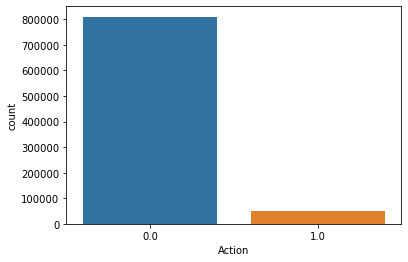

In [126]:
cols = ['wheelRotationalSpeedX','frameRotationalSpeedY','frAcc','Action']

df = df[cols]

# Fill NaN with 0
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df = df.fillna(0)

#Convert Sprinting to 1
df.Action.replace({'Sprinting': 1},inplace=True)

sns.countplot(df['Action'])

/opt/jupyterhub/anaconda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Action', ylabel='count'>

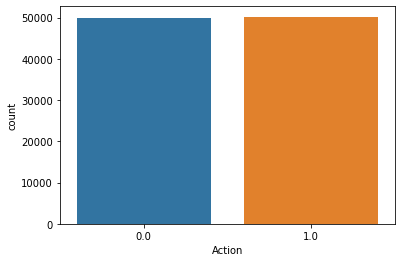

In [127]:
# Separate majority and minority classes
df_majority = df[df.Action==0]
df_minority = df[df.Action==1]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=50000,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority])
 
sns.countplot(df['Action'])

In [128]:
X = df[['wheelRotationalSpeedX','frameRotationalSpeedY','frAcc']]
y = df[['Action']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Convert the X_train, X_test, y_train, y_test to Tensors

In [129]:
X_train = torch.from_numpy(X_train.to_numpy()).float()
y_train = torch.squeeze(torch.from_numpy(y_train.to_numpy()).float())
X_test = torch.from_numpy(X_test.to_numpy()).float()
y_test = torch.squeeze(torch.from_numpy(y_test.to_numpy()).float())
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([80152, 3]) torch.Size([80152])
torch.Size([20039, 3]) torch.Size([20039])


# NN def
Define the Neural Network

In [130]:
class NN_model(nn.Module):
  def __init__(self, n_features):
    super(NN_model, self).__init__()
    self.fc1 = nn.Linear(n_features, 10)
    self.fc2 = nn.Linear(10, 5)
    self.fc3 = nn.Linear(5, 1)
    
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    return torch.sigmoid(self.fc3(x))

NN = NN_model(X_train.shape[1])

# Training the NN on the GPU


In [131]:
criterion = nn.BCELoss()

optimizer = optim.Adam(NN.parameters(), lr=0.001)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)
NN = NN.to(device)
criterion = criterion.to(device)

# Define functions for calculating Accuracy of model

In [132]:
def calculate_accuracy(y_true, y_pred):
    predicted = y_pred.ge(.5).view(-1)
    return (y_true == predicted).sum().float() / len(y_true)

# For loop through different epochs

In [133]:
def round_tensor(t, decimal_places=3):
  return round(t.item(), decimal_places)

for epoch in range(1000):
    y_pred = NN(X_train)
    y_pred = torch.squeeze(y_pred)
    train_loss = criterion(y_pred, y_train)
    
    if epoch % 100 == 0:
        
        train_acc = calculate_accuracy(y_train, y_pred)
        
        y_test_pred = NN(X_test)
        
        y_test_pred = torch.squeeze(y_test_pred)
        
        test_loss = criterion(y_test_pred, y_test)
        
        test_acc = calculate_accuracy(y_test, y_test_pred)
        
        print(
f'''epoch {epoch}
Train set - loss: {round_tensor(train_loss)}, accuracy: {round_tensor(train_acc)}
Test  set - loss: {round_tensor(test_loss)}, accuracy: {round_tensor(test_acc)}
''')
    optimizer.zero_grad()
    
    train_loss.backward()
    
    optimizer.step()

epoch 0
Train set - loss: 21.748, accuracy: 0.545
Test  set - loss: 21.952, accuracy: 0.546

epoch 100
Train set - loss: 0.567, accuracy: 0.575
Test  set - loss: 0.565, accuracy: 0.578

epoch 200
Train set - loss: 0.514, accuracy: 0.776
Test  set - loss: 0.512, accuracy: 0.774

epoch 300
Train set - loss: 0.424, accuracy: 0.818
Test  set - loss: 0.423, accuracy: 0.817

epoch 400
Train set - loss: 0.335, accuracy: 0.867
Test  set - loss: 0.332, accuracy: 0.868

epoch 500
Train set - loss: 0.307, accuracy: 0.881
Test  set - loss: 0.304, accuracy: 0.885

epoch 600
Train set - loss: 0.295, accuracy: 0.883
Test  set - loss: 0.291, accuracy: 0.887

epoch 700
Train set - loss: 0.292, accuracy: 0.883
Test  set - loss: 0.288, accuracy: 0.887

epoch 800
Train set - loss: 0.291, accuracy: 0.884
Test  set - loss: 0.287, accuracy: 0.887

epoch 900
Train set - loss: 0.29, accuracy: 0.884
Test  set - loss: 0.286, accuracy: 0.888



# Validate/Tune Model

Validate results of the model (Precision/Recall). Tune the parameters of the model to achieve better results

In [134]:
classes = ['Not Sprinting', 'Sprinting']
y_pred = NN(X_test)
y_pred = y_pred.ge(.5).view(-1).cpu()
y_test = y_test.cpu()
print(classification_report(y_test, y_pred, target_names=classes))

               precision    recall  f1-score   support

Not Sprinting       0.91      0.86      0.88     10037
    Sprinting       0.87      0.92      0.89     10002

     accuracy                           0.89     20039
    macro avg       0.89      0.89      0.89     20039
 weighted avg       0.89      0.89      0.89     20039



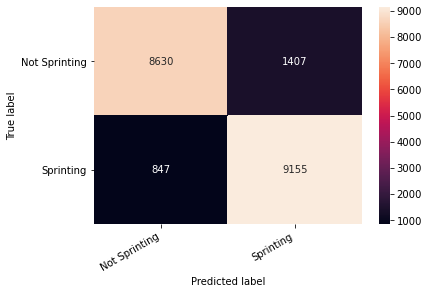

In [135]:
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=classes, columns=classes)
hmap = sns.heatmap(df_cm, annot=True, fmt="d")
hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label');

# Saving Model

MODEL_PATH = 'model.pth'

torch.save(NN, MODEL_PATH)

# Restoring Model

NN = torch.load(MODEL_PATH)